In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math

import biojepa_ac_model as model

In [6]:
from umap import UMAP
import hdbscan
import datamapplot

In [7]:
torch.manual_seed(1337)
random.seed(1337)

def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [8]:
BATCH_SIZE = 32
n_embd = 8
n_pathways = 1024
training_file_chunk = 25000
pretraining_file_chunk = 50000
n_heads = 1
n_layers = 1

In [9]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
mask_path = data_dir / 'binary_pathway_mask.npy'
metadata_path = data_dir / 'perturbation_map.json'
checkpoint_dir = data_dir / 'checkpoint'
gene_names_path = data_dir / 'gene_names.json'

In [10]:
print('Loading Pathway Mask...')
binary_mask = np.load(mask_path)
n_genes, n_pathways = binary_mask.shape
print(f'Mask Loaded: {n_genes} Genes -> {n_pathways} Pathways')

with open(metadata_path, 'r') as f:
    pert_map = json.load(f)
id_to_pert = {v: k for k, v in pert_map.items()}
print(f'Loaded {len(id_to_pert.keys())} perturbations')

with open(gene_names_path, 'r') as f:
    gene_names = json.load(f)
print(f'Loaded {len(gene_names)} genes')

Loading Pathway Mask...
Mask Loaded: 5000 Genes -> 1024 Pathways
Loaded 1088 perturbations
Loaded 5000 genes


In [11]:
config = model.BioJepaConfig(
    mask_matrix=binary_mask, 
    num_genes=n_genes,
    num_pathways=n_pathways,
    embed_dim=n_embd,
    n_layer=n_layers,
    heads=n_heads,
    n_pre_layer = n_layers
)
model = model.BioJepa(config).to(DEVICE)

In [12]:
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_6353_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

In [14]:
gene_embd = model.student.gene_embeddings.detach().cpu().float().numpy()
gene_embd.shape

(5000, 8)

In [16]:
n = gene_embd.shape[0]
n

5000

In [19]:
labels = np.asarray(gene_names) 

In [25]:
coords = UMAP(
    n_components=2, 
    n_neighbors=30, 
    min_dist=0.5, 
    spread=2.0, 
    metric="cosine", 
    random_state=0).fit_transform(gene_embd)

/opt/miniconda3/envs/general/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<InteractiveFigure width=100% height=800>
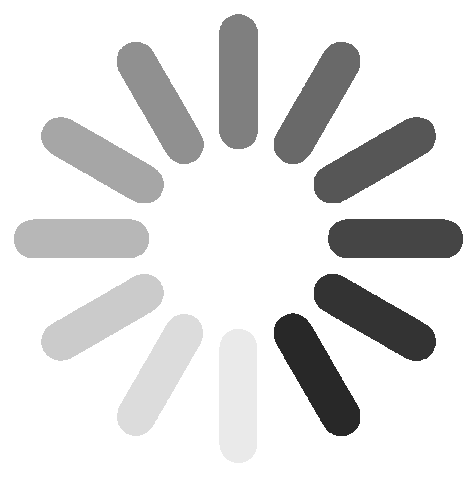

In [26]:
datamapplot.create_interactive_plot(coords, labels)

In [27]:
from sklearn.manifold import TSNE

In [34]:
coords = TSNE(
    n_components=2,
    perplexity=30,      
    learning_rate='auto',
    init='random',
    random_state=12
).fit_transform(gene_embd)

<InteractiveFigure width=100% height=800>
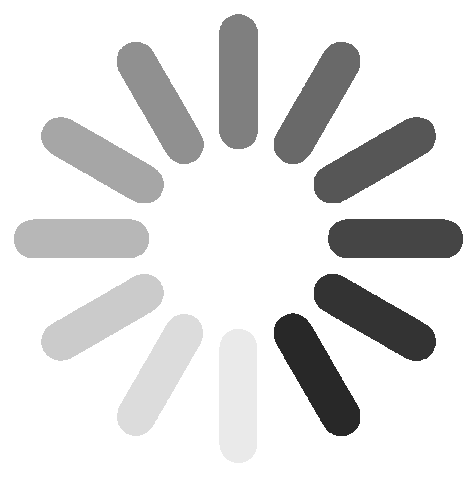

In [35]:
datamapplot.create_interactive_plot(coords, labels)